# Project Description

Sweet Lift Taxi company has collected historical data on taxi orders at airports.

To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.

Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


# imports

In [56]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
import math

# Download the data and resample it by one hour

In [57]:
try:
    path='C:\\Users\\aviv\\Downloads\\taxi.csv'
    data = pd.read_csv(path, index_col=[0], parse_dates=[0])
    display(data.head())
    
except:
    path = '/datasets/taxi.csv'
    data = pd.read_csv(path, index_col=[0], parse_dates=[0])
    print(data.head())
    
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head())



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Analyze the data

<AxesSubplot:xlabel='datetime'>

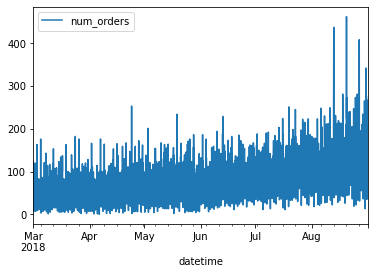

In [58]:
display(data.plot())



we can see a little cyclicity, we can probably extract it

<AxesSubplot:xlabel='datetime'>

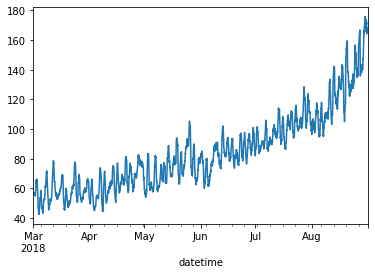

In [59]:
decomposed = seasonal_decompose(data)
display(decomposed.trend.plot())


the trend is interesting, it's as if when spring arrives people want to get out and use their feet more, and as the summer and winter approach they lose their patience and use more and more taxis.

<AxesSubplot:xlabel='datetime'>

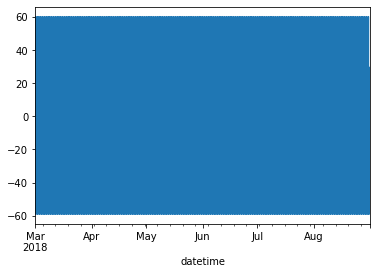

In [60]:
display(decomposed.seasonal.plot())

that's solid. let's look at a smaller slice:

<AxesSubplot:xlabel='datetime'>

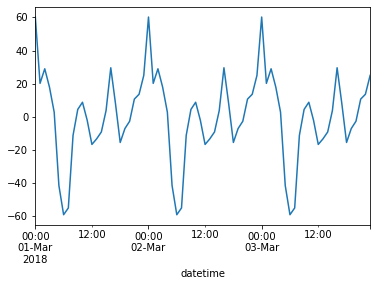

In [61]:
display(decomposed.seasonal['2018-03-01':'2018-03-03'].plot());

regular peaks at midnight, and a sharp drop until about 6 in the morning, where people start getting to work.

after that a rise until lunch time, drop until supper, then rise until midnight.

<AxesSubplot:xlabel='datetime'>

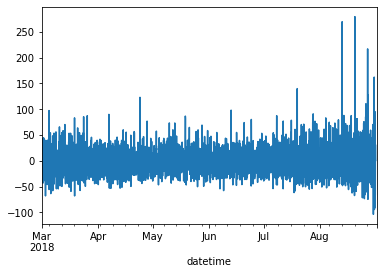

In [62]:
display(decomposed.resid.plot())

<AxesSubplot:xlabel='datetime'>

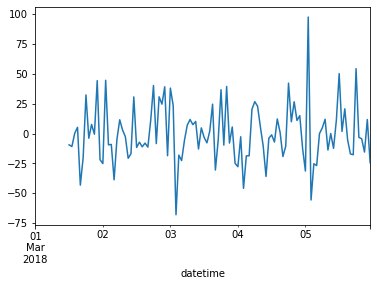

In [63]:
display(decomposed.resid['2018-03-01':'2018-03-05'].plot())

that's just noise but there's more noise (more orders that aren't part of the trend and the regulars) towards the end of the series. more people use taxis as the autumn arrives and with it more rainy days.

making features to forecast with:

In [64]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 5, 5)
display(data.head(10))

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,28.4


# Train different models with different hyperparameters. the test sample should be 10% of the initial dataset

## split the dataset

before the split, encoding cyclical features using trig functions:

In [65]:
categorical_feats = ['month','day','dayofweek','hour']
for c in categorical_feats:
    data[f'{c}_norm'] = 2 * math.pi * data[c] / data[c].max()

    data[f'cos_{c}'] = np.cos(data[f'{c}_norm'])
    data[f'sin_{c}'] = np.sin(data[f'{c}_norm'])
                                   
                               

In [66]:
# x = data.drop('num_orders',axis=1)
# y = data.num_orders
data.drop(['month','day','dayofweek','hour','month_norm','day_norm','hour_norm','dayofweek_norm'],axis=1, inplace=True)

train, test = train_test_split(data, test_size=0.2, shuffle=False)
train=train.dropna()

valid, test = train_test_split(test, test_size=0.5, shuffle=False)

x_train = train.drop('num_orders', axis=1)
y_train = train.num_orders

x_valid = valid.drop('num_orders', axis=1)
y_valid = valid.num_orders

x_test = test.drop('num_orders', axis=1)
y_test = test.num_orders
# train and test split
# x_train, x_valid, y_train, y_valid = train_test_split(
#     x, y, test_size=0.2, shuffle=False)
# x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5,
#                                                                            shuffle=False)
#x_train = x_train.dropna()

## standardizing features:

we don't want to scale the cyclical features as they've already been standardized

In [67]:
scaler = StandardScaler()
numeric = ['lag_1','lag_2','lag_3','lag_4','lag_5','rolling_mean']
scaler.fit(x_train[numeric])

x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric]) 
x_test[numeric] = scaler.transform(x_test[numeric])

## Linear regression

In [68]:
model=LinearRegression()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_valid = model.predict(x_valid)
# y_pred_test = model.predict(x_test)




print("RMSE for the training set:", mean_squared_error(y_train, y_pred_train)**0.5)
print("RMSE for the validation set: ", mean_squared_error(y_valid, y_pred_valid)**0.5) 

RMSE for the training set: 27.82765441208945
RMSE for the validation set:  41.87913953899355


## Random forest regression

In [69]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_valid = model.predict(x_valid)




print("RMSE for the training set:", mean_squared_error(y_train, y_pred_train)**0.5)
print("RMSE for the validation set: ", mean_squared_error(y_valid, y_pred_valid)**0.5) 

RMSE for the training set: 8.048788047122507
RMSE for the validation set:  40.13139884558184


In [70]:
model = RandomForestRegressor(n_estimators = 50)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_valid = model.predict(x_valid)




print("RMSE for the training set:", mean_squared_error(y_train, y_pred_train)**0.5)
print("RMSE for the validation set: ", mean_squared_error(y_valid, y_pred_valid)**0.5) 

RMSE for the training set: 8.279246311006224
RMSE for the validation set:  39.185899232281685


now for our secret weapon - 
## LightGBM

In [71]:
import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 30,
    'learning_rate': 0.4,
    'metric': {'rmse'},
    'verbose': 2
}

# loading data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

model = lgb.train(params,
                  num_boost_round = 30,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.013184
[LightGBM] [Debug] init for col-wise cost 0.000015 seconds, init for row-wise cost 0.005205 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 3527, number of used features: 14
[LightGBM] [Info] Start training from score 74.302523
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[1]	valid_0's rmse: 47.6122
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[2]	valid_0's rmse: 42.1076
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[3]	valid_0's rmse: 38.1691
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[4]	valid_0's rmse: 36.44

In [72]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.1,
    'metric': {'rmse'},
    'verbose': 2
}

# loading data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

model = lgb.train(params,
                  num_boost_round = 30,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.013184
[LightGBM] [Debug] init for col-wise cost 0.000751 seconds, init for row-wise cost 0.002318 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 3527, number of used features: 14
[LightGBM] [Info] Start training from score 74.302523
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 13
[1]	valid_0's rmse: 55.2882
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 14
[2]	valid_0's rmse: 52.681
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 14
[3]	valid_0's rmse: 50.404
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 13
[4]	valid_0's rmse:

# Test the data using the test sample and provide a conclusion

best model was random forest with n_est=50. now to train on training+validation sets and test on test set

In [73]:
model = RandomForestRegressor(n_estimators=50)
model.fit(pd.concat([x_train,x_valid]), pd.concat([y_train,y_valid]))
y_pred_train = model.predict(pd.concat([x_train,x_valid]))
y_pred_valid = model.predict(x_test)




print("RMSE for the training+validation sets:", mean_squared_error(pd.concat([y_train,y_valid]), y_pred_train)**0.5)
print("RMSE for the test set: ", mean_squared_error(y_test, y_pred_valid)**0.5) 

RMSE for the training+validation sets: 8.61434826432902
RMSE for the test set:  44.758601296792655


# Conclusion

our best model was against my expectations the random forest with a lowered number of estimators. goes to show sometimes the flashy machines (i'm looking at you, LightGBM) don't always do the best job. 